## Fitting Rb 87

Importing packages

In [8]:
import numpy as np 
from scipy.optimize import curve_fit
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

Importing data and plotting spectrum for 1 file

0.007949999999999999
[1.56926762e+02 7.25198751e-02 1.29509635e+00] [1.78846665 0.0073787  0.02088507]
The linewidth is 1.2950963477213393 pm 0.020885072632157855 Mhz
The Chi Squared is 294.21762574235265
The Reduced Chi Squared is 1.4934904860017901


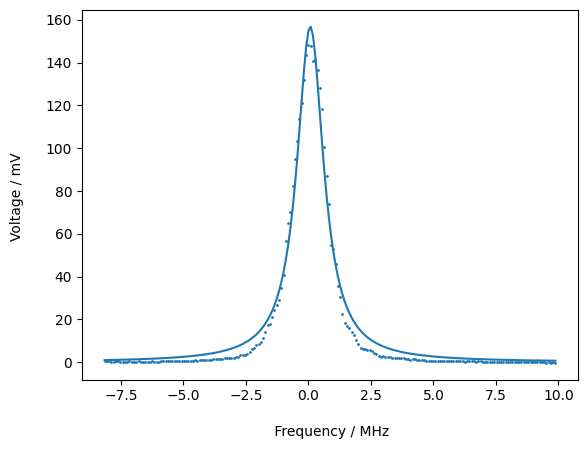

In [9]:
## Location of No Insulation Data
path = 'I:/Science/Physics-Photonics/Group/Allan_OPM_MEMS_Fab_and_Clocks/PostDoc_Mainly_RbTPT/TPT_signal_data/Infleqtion_wafer/Infleqtion_Phoenix_wafer/Infleqtion_Phoenix_wafer/Abi/InsulationTest/2025-11-19-NoInsulation'

## Collect paths of all CSV files from folder into a list
csv_files = glob.glob(os.path.join(path, "*.csv"))
numb_files = len(csv_files) # The number of files

## Take first file and extract data into dataframe
df = pd.read_csv(csv_files[0])

## Display data frame
df.head()

## extracting time base (x) and amplitude (y) data
## ommiting column heading
x = (df['x-axis'].to_numpy())[1:] 
y = (df['1'].to_numpy())[1:]

## Converting data to float
x = x.astype(float)
y = y.astype(float)

## Imverting signal
y = np.flip(y)

# Find Peaks - adjusted params to only find 2 peaks
p, properties = find_peaks(y, height = 0.07, distance = 5, prominence = 0.02)

# rescale x and y axes
ptime = np.array([p[0],p[1]])
deltat = x[ptime[1]] - x[ptime[0]]
deltaf = 14.412 #MHz
# zero point is set to centre of largest peak; freq is in MHz
freq = -(x - x[ptime[0]]) * deltaf / deltat

print(deltat)

# Get rid of y offset
sig = (y - np.mean(y[0:9]))*1e3 #NB units are mV

## Chop data to focus on biggest peak
sigp = sig[900:1100]
freqp = freq[900:1100]

## Fitting - Loretzian dist.
# 3 params - amplitude A, centre point C, linewidth gamma (FWHM)

def lorentz(xdata,A,C,gamma): 
    x1 = (xdata-C)/(gamma/2)
    return A / (1 + x1**2)

guess = np.array([140,0,2])

popt,pcov = curve_fit(lorentz,freqp,sigp,p0=guess)
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

print('The linewidth is {} pm {} Mhz'.format(popt[2],perr[2]))

## Chi Squared

dof = np.size(freqp) - np.size(popt) 

def chi_squared(xdata,ydata,f,params):
    return np.sum(((ydata - f(xdata,*params))**2) / f(xdata,*params))

cs = chi_squared(freqp,sigp,lorentz,popt)
red_cs = cs / dof
print('The Chi Squared is {}'.format(cs))
print('The Reduced Chi Squared is {}'.format(red_cs))


plt.scatter(freqp,sigp, s = 1)
plt.plot(freqp,lorentz(freqp,*popt))
for i in p:
    # plt.scatter(freq[i],sig[i], c = 'r', marker = 'x')
    plt.xlabel('\n Frequency / MHz')
    plt.ylabel('Voltage / mV \n')
